In [5]:
from __future__ import print_function
#import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import seaborn as sns
import os
import glob
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

In [6]:
# preprocess news data
symbols = []
text = []
date = []
with open("../shared/stock_data/data/news_article/newsdata.txt", 'rb') as myfile:
    for line in myfile.readlines():
        line = line.strip("\n").strip("\r").split("||")
        symbols.append(line[0])
        text.append(line[1])
        date.append(line[2])
news_dataset = pd.DataFrame({"company": symbols, "text": text, "date":date})

In [7]:
news_dataset.sample(5)

,company,date,text
27999,ITW,2017-10-26,Illinois Tool Works Named Top Dividend Stock W...
24286,GE,2016-07-22,GE Q2 GAAP continuing operations earnings$0.36...
19525,EA,2017-11-10,Respawn Entertainment Acquired for $455 Million
43609,RSG,2017-11-06,Republic Services increases income inQ3
37632,NEE,2017-09-25,Nextera Energy says NEP OPCO issued $550 milli...


In [9]:
price_movement_data_list = []
for f in glob.glob('../shared/stock_data/data/price_movement/*.csv'):
    dataset_file = pd.read_csv( f, sep=',', comment='#',  
                      index_col = False, encoding='utf-8')
    dataset_file['Comp_code'] = os.path.splitext(os.path.basename(f))[0]
    price_movement_data_list.append(dataset_file)

price_movement_dataset   = pd.concat(price_movement_data_list, ignore_index=True, axis = 0)

In [10]:
price_movement_dataset.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Comp_code
4441,2017-08-28,236.220001,237.550003,234.610001,237.179993,237.179993,2395000,BA
42580,2013-02-25,76.470001,76.660004,75.570000,75.570000,66.628731,10603300,JNJ
36169,2005-07-12,5.461429,5.485714,5.415714,5.462857,4.914692,96759600,AAPL
664,2002-08-27,37.099998,37.689999,36.590000,37.029999,26.202003,2878600,BA
32734,2009-09-23,16.860001,16.879999,16.410000,16.430000,12.206116,48134200,PFE


In [11]:
revenue_data_list = []
for f in glob.glob('../shared/stock_data/data/revenue/*.csv'):
    dataset_file = pd.read_csv( f, sep=',', comment='#',  
                      index_col = False, encoding='utf-8')
    dataset_file['Comp_code'] = os.path.splitext(os.path.basename(f))[0].split('_')[0]
    revenue_data_list.append(dataset_file)

revenue_dataset   = pd.concat(revenue_data_list, ignore_index=True, axis = 0)

In [12]:
revenue_dataset.head()

,ticker,year,quarter,basicdilutedeps,basiceps,cashdividendspershare,dilutedeps,incometaxexpense,netincome,netincomecontinuing,...,totalinterestexpense,totaloperatingexpenses,totaloperatingincome,totalotherincome,totalpretaxincome,totalrevenue,weightedavebasicdilutedsharesos,weightedavebasicsharesos,weightedavedilutedsharesos,Comp_code
0,AMZN,2009,Q1,0.41,0.41,0.0,0.41,69000000.0,177000000.0,177000000.0,...,12000000.0,4.820000e+08,2.440000e+08,4000000.0,2.480000e+08,4.889000e+09,431700000.0,429000000.0,437000000.0,AMZN
1,AMZN,2009,Q2,0.33,0.33,0.0,0.32,39000000.0,142000000.0,142000000.0,...,7000000.0,5.650000e+08,1.590000e+08,20000000.0,1.790000e+08,4.651000e+09,430300000.0,431000000.0,440000000.0,AMZN
2,AMZN,2009,Q3,0.46,0.46,0.0,0.45,60000000.0,199000000.0,199000000.0,...,7000000.0,5.560000e+08,2.510000e+08,11000000.0,2.620000e+08,5.449000e+09,432600000.0,432000000.0,441000000.0,AMZN
3,AMZN,2009,Q4,0.88,0.88,0.0,0.86,85000000.0,384000000.0,384000000.0,...,8000000.0,7.470000e+08,4.750000e+08,-3000000.0,4.720000e+08,9.520000e+09,433700000.0,433000000.0,442000000.0,AMZN
4,AMZN,2009,FY,2.08,2.08,0.0,2.04,253000000.0,902000000.0,902000000.0,...,34000000.0,2.350000e+09,1.129000e+09,32000000.0,1.161000e+09,2.450900e+10,433700000.0,433000000.0,442000000.0,AMZN


# Exporatory Data Analysis

<b> 1. Explore different ways of extracting feature information from news articles

In [13]:
price_movement_dataset['Comp_code'].unique()

array(['BA', 'T', 'F', 'AMZN', 'MSFT', 'GE', 'GOOG', 'PFE', 'AAPL', 'JNJ'],
      dtype=object)

In [14]:
from pandas.tseries.offsets import MonthEnd

/Library/Python/2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


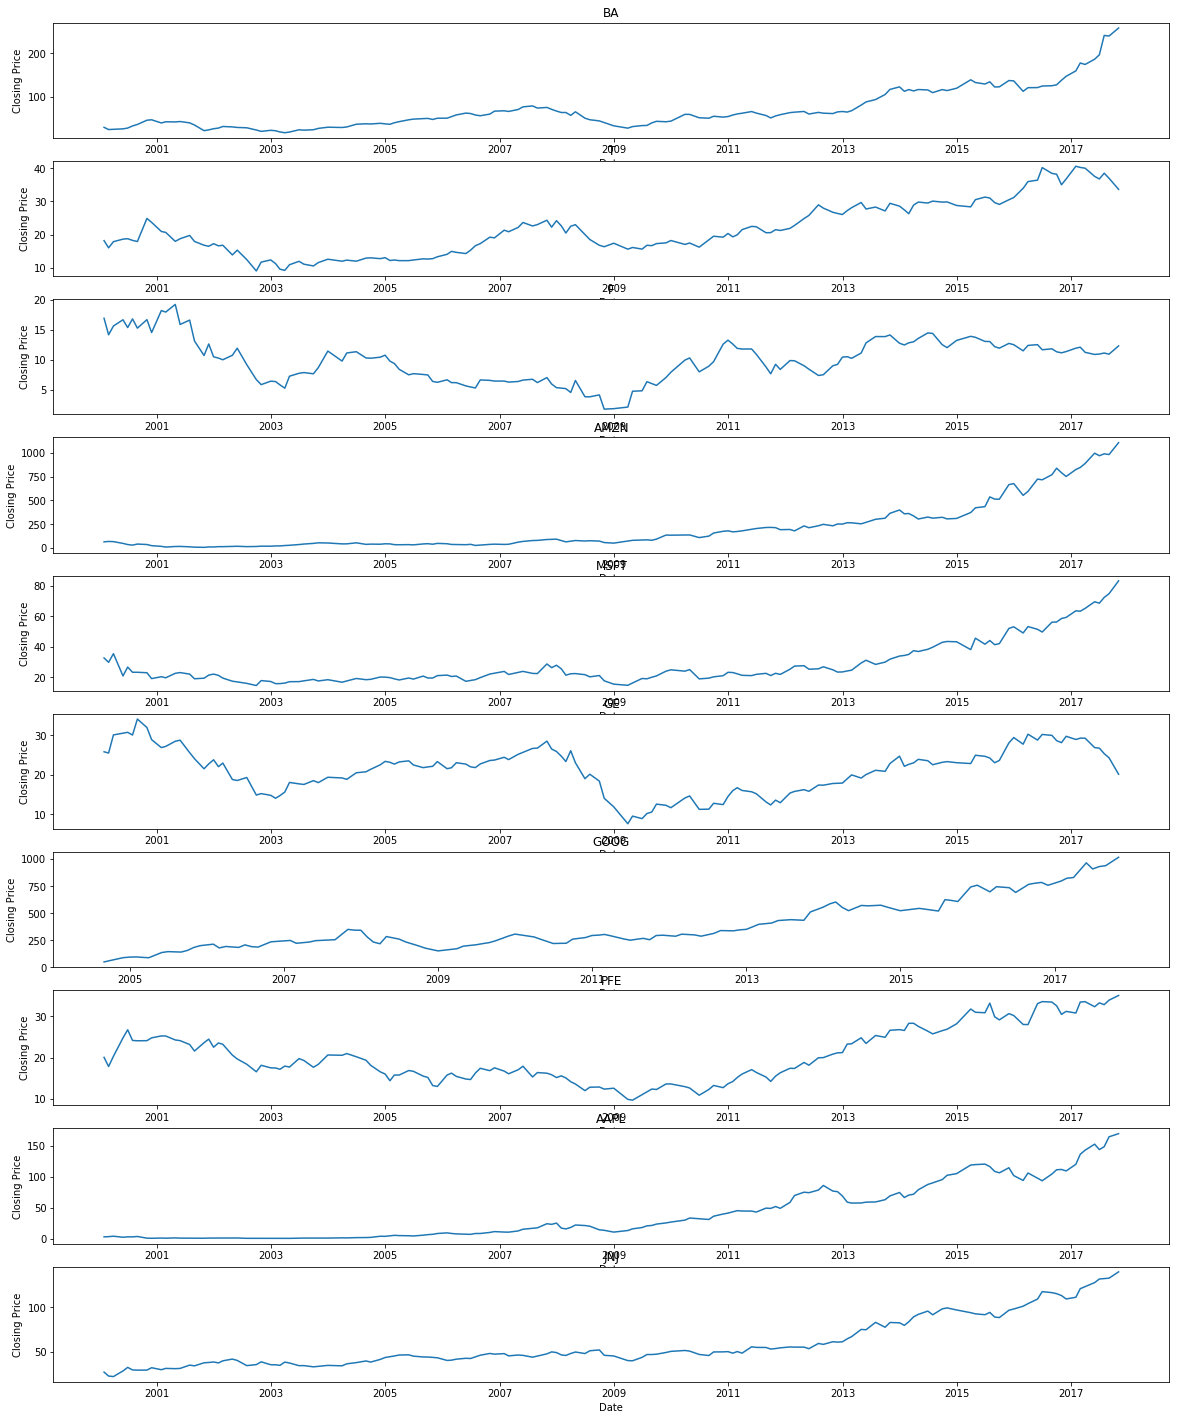

In [15]:
fig = plt.figure(figsize=(20,25))
#plt.subplots_adjust(top = 1, bottom = .8)
for index, comp_code in enumerate(price_movement_dataset['Comp_code'].unique()):
    ax = plt.subplot(len(price_movement_dataset['Comp_code'].unique()),1,index+1)
    comp_price_movement_dataset = price_movement_dataset.loc[price_movement_dataset.Comp_code == comp_code].copy()
    comp_price_movement_dataset['Date'] = pd.to_datetime(comp_price_movement_dataset['Date'])
    comp_price_movement_dataset['end_of_month'] = pd.to_datetime(comp_price_movement_dataset['Date'], format="%Y-%m") + MonthEnd(0)
    monthly_price_movement = comp_price_movement_dataset.loc[comp_price_movement_dataset.Date == comp_price_movement_dataset.end_of_month]
    ax.plot(monthly_price_movement['Date'], monthly_price_movement['Adj Close'])
    ax.set_title(comp_code)
    ax.set_xlabel("Date")
    ax.set_ylabel("Closing Price")
    

In [11]:
# Top 3 performins stocks are Amazon(AMZN), Google(GOOG), Apple (AAPL)

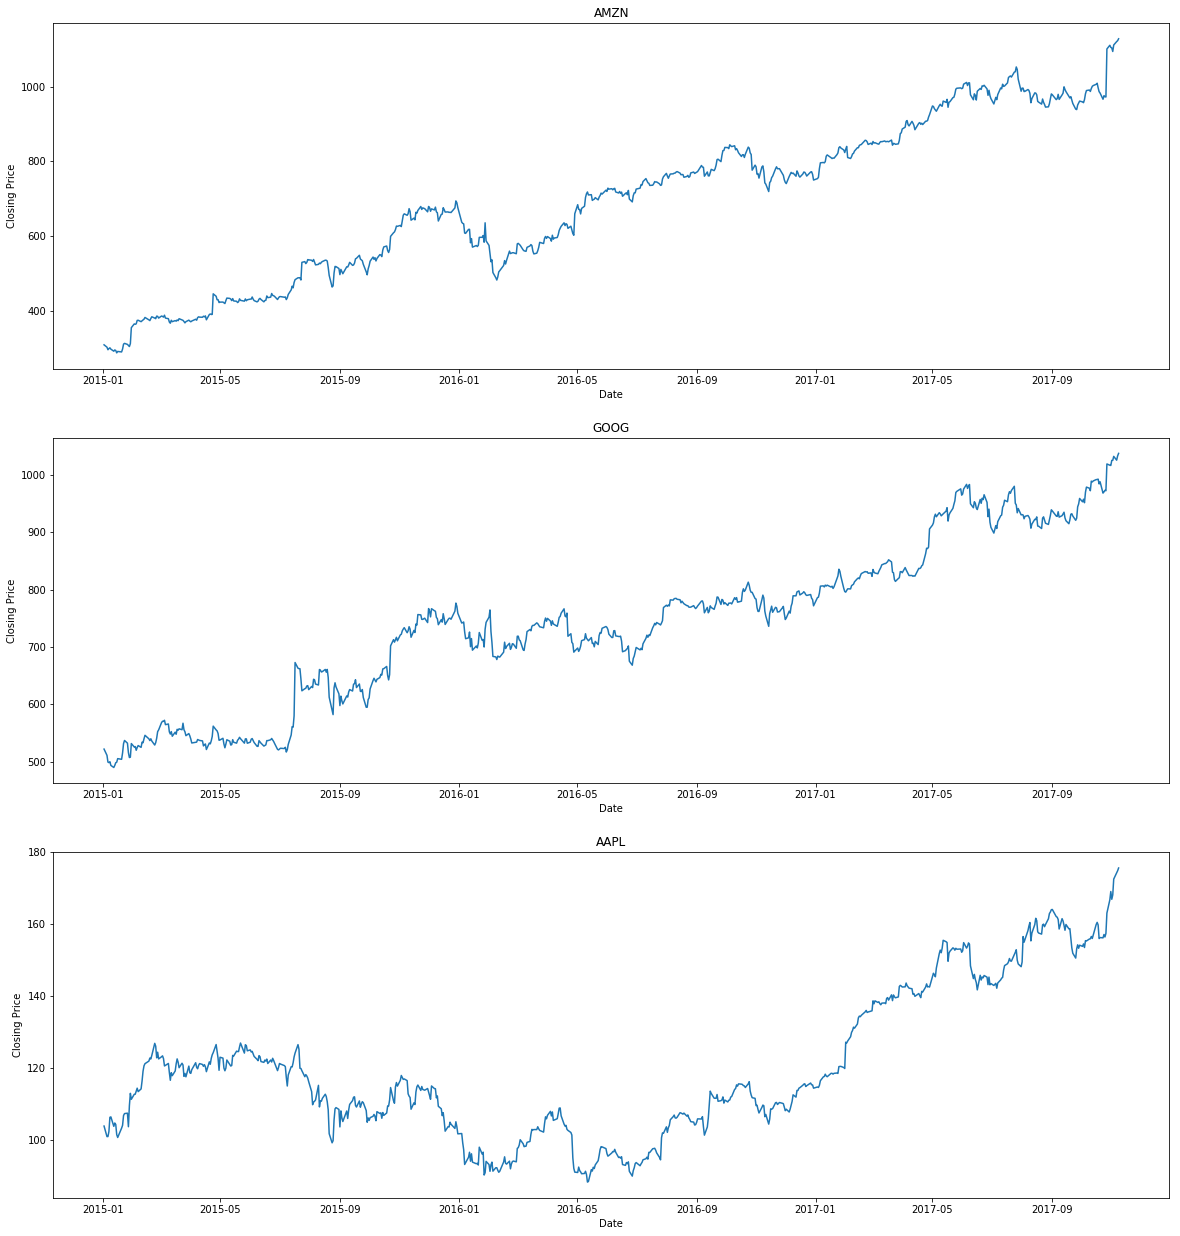

In [16]:
# get data for apple
fig = plt.figure(figsize=(20,75))
# amazon price movement dataset
for index, comp_code in enumerate(['AMZN', 'GOOG', 'AAPL']):
    ax = plt.subplot(len(price_movement_dataset['Comp_code'].unique()),1,index+1)
    comp_price_movement_dataset = price_movement_dataset.loc[price_movement_dataset.Comp_code == comp_code].copy()
    comp_price_movement_dataset['Date'] = pd.to_datetime(comp_price_movement_dataset['Date'])
    comp_monthly_price_movement_dataset_last_yrs = comp_price_movement_dataset.loc[comp_price_movement_dataset.Date.dt.year > comp_price_movement_dataset.Date.dt.year.max()-3]
    ax.plot(comp_monthly_price_movement_dataset_last_yrs['Date'], comp_monthly_price_movement_dataset_last_yrs['Adj Close'] )
    ax.set_title(comp_code)
    ax.set_xlabel("Date")
    ax.set_ylabel("Closing Price")

<b> For these three stocks, there is no seasonality in data, but there is increasing trends

Top 3 performins strocks are Amazon(AMZN), Google(GOOG), Apple (AAPL)

2. Explore different ways of extracting feature information from news articles

In [17]:
def get_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity
def get_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

In [18]:
# sentiments
news_dataset["positivity"] = news_dataset['text'].map(lambda x : get_polarity(x))
# public opinion
news_dataset["subjectivity"] = news_dataset['text'].map(lambda x : get_subjectivity(x))
news_dataset['buy'] = news_dataset['text'].map(lambda x : 1 if 'buy' in x.lower() else 0)
news_dataset['sell'] = news_dataset['text'].map(lambda x : 1 if 'sell' in x.lower() else 0)

news_dataset["financial_report_quarter"] = 0
news_dataset.ix[news_dataset['text'].str.upper().str.contains('REPORTS Q'),"financial_report_quarter"] = pd.to_datetime(news_dataset['date']).dt.quarter

/Users/mkumar5/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


In [19]:
news_data_sentiments = news_dataset[['company', 'date','positivity', 'subjectivity', 'buy', 'sell']]
news_data_sentiments = news_data_sentiments.groupby(['company', 'date'], as_index=False).agg(sum)
news_data_sentiments.head()

,company,date,positivity,subjectivity,buy,sell
0,A,2015-11-19,0.0,0.0,0,0
1,A,2015-12-08,0.0,0.0,0,0
2,A,2016-01-06,0.0,0.0,0,0
3,A,2016-05-16,0.0,0.0,0,0
4,A,2016-08-17,0.0,0.0,0,0


<b> 3. For the top 3 performing stocks, observe if there is any correlation between the sentiment conveyed in the news article on a particular day and their price movement over the next 5 days for which the data is available.

In [20]:
def next_5_days_corelation(row, price_movement_top_3_dataset):
    try :
        x = price_movement_top_3_dataset[price_movement_top_3_dataset.Date==row.date].index.values[0] 
        val1 = val2 = val3 = val4 = val5 = -1
        if x:
            val = price_movement_top_3_dataset.loc[price_movement_top_3_dataset.index == x]['Adj Close'].values[0]
            if price_movement_top_3_dataset.shape[0]>x+1:
                val1 = price_movement_top_3_dataset.loc[price_movement_top_3_dataset.index == x+1]['Adj Close'].values[0]
            if price_movement_top_3_dataset.shape[0]>x+2:
                val2 = price_movement_top_3_dataset.loc[price_movement_top_3_dataset.index == x+2]['Adj Close'].values[0]
            if price_movement_top_3_dataset.shape[0]>x+3:
                val3 = price_movement_top_3_dataset.loc[price_movement_top_3_dataset.index == x+3]['Adj Close'].values[0]
            if price_movement_top_3_dataset.shape[0]>x+4:
                val4 = price_movement_top_3_dataset.loc[price_movement_top_3_dataset.index == x+4]['Adj Close'].values[0]
            if price_movement_top_3_dataset.shape[0]>x+5:
                val5 = price_movement_top_3_dataset.loc[price_movement_top_3_dataset.index == x+5]['Adj Close'].values[0]
            return ((val1+val2+val3+val4+val5)*1.0/5) - val
    except Exception as ex:
        return 0

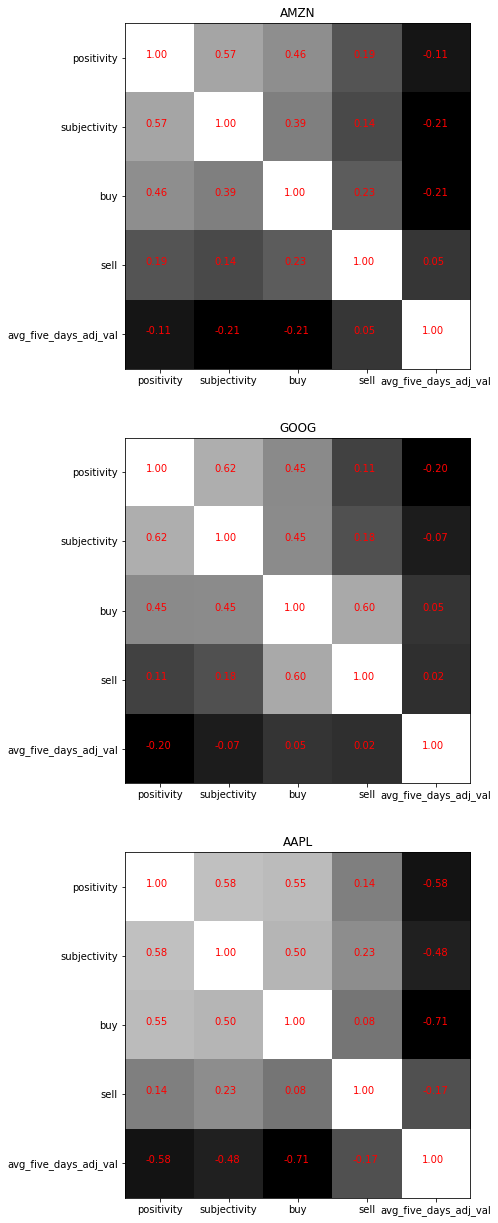

In [21]:
# get data for top 3 companies

price_movement_top_3_dataset = price_movement_dataset.loc[price_movement_dataset.Comp_code.isin(['AMZN'])].copy().reset_index()
news_data_sentiments_top_3_dataset = news_data_sentiments.loc[news_data_sentiments.company.isin(['AMZN'])].copy().reset_index()

fig = plt.figure(figsize=(20,75))
# amazon price movement dataset
for index, comp_code in enumerate(['AMZN', 'GOOG', 'AAPL']):
    ax = plt.subplot(len(price_movement_dataset['Comp_code'].unique()),1,index+1)
    comp_price_movement__top_3_dataset = price_movement_dataset.loc[price_movement_dataset.Comp_code == comp_code].copy().reset_index()
    news_data_sentiments_top_3_dataset = news_data_sentiments.loc[news_data_sentiments.company == comp_code].copy().reset_index()
    
    news_data_sentiments_top_3_dataset['avg_five_days_adj_val'] = news_data_sentiments_top_3_dataset.apply(lambda row: next_5_days_corelation(row, comp_price_movement__top_3_dataset)
                                                            ,axis=1)
    
    news_data_sentiments_top_3_dataset_corr = news_data_sentiments_top_3_dataset[['positivity', 'subjectivity', 'buy', 'sell', 'avg_five_days_adj_val']].corr()
    
    ax.imshow(news_data_sentiments_top_3_dataset_corr, cmap=plt.cm.gray)
    for i in range(news_data_sentiments_top_3_dataset_corr.shape[0]):
        for j in range(news_data_sentiments_top_3_dataset_corr.shape[0]):
            ax.text(i-0.2,j, "%.2f"%(news_data_sentiments_top_3_dataset_corr.iloc[i,j]), color='r')
    ax.set_title(comp_code)
    ax.set_yticklabels(['', 'positivity', 'subjectivity', 'buy', 'sell', 'avg_five_days_adj_val'])
    ax.set_xticklabels(['', 'positivity', 'subjectivity', 'buy', 'sell', 'avg_five_days_adj_val'])


# Forecasting

In [22]:
# revenue data
def quarters_to_date(year, quarter):
    '''
    Map quarter to date
    '''
    q2d = {'Q1': '-05-01',
           'Q2': '-08-01',
           'Q3': '-11-01',
           'Q4': '-02-01',
           'FY': '-04-01',
           }
    day = q2d[quarter]
    if (quarter in ('Q4', 'FY')):
        year += 1

    return str(year) + day

In [23]:
'''
Create time-series supervised data from the original data
'''
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    #for i in range(0, n_out):
    for i in [n_out-1]:
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [24]:
# prepare data for training for each company
def prepare_dataset(n_lags, n_forecast, include_news_dataset=True):
    datasets = {}
    org_datasets = {}
    for f in glob.glob('../shared/stock_data/data/price_movement/*.csv'):
        dataset = pd.read_csv( f, sep=',', comment='#',  
                          index_col = False, encoding='utf-8')
        comp_code = os.path.splitext(os.path.basename(f))[0]

        dataset = dataset.set_index('Date')
        cols = list(dataset)
        # Move 'Adj Close'  to last column
        cols.insert(len(cols)-1, cols.pop(cols.index('Adj Close')))
        dataset = dataset.ix[:, cols]

        dropped_cols = ['Open', 'High', 'Low', 'Close']
        for col in dropped_cols:
            dataset = dataset.drop(col, axis=1)

        # revenue data
        revenue_path = '../shared/stock_data/data/revenue/' + comp_code + "_Financials_by_Quarter.csv"
        revenue_dataset = pd.read_csv(revenue_path, header=0, parse_dates=[0], index_col=0, squeeze=True)
        revenue_dataset['date'] = revenue_dataset.apply(lambda row: quarters_to_date(row.year, row.quarter), axis=1).astype('datetime64[ns]')                                                                                               
        revenue_dataset = revenue_dataset.set_index('date')

        # randomly select columns
        revenue_cols = ['basiceps', 'netincome', 'totalrevenue', 'totalgrossprofit']
        revenue_dataset = revenue_dataset[revenue_cols]

        result = pd.merge(revenue_dataset, dataset, left_index=True, right_index=True, how='right')
        result[revenue_cols] = result[revenue_cols].fillna(method='ffill')

    
        # news data
        if include_news_dataset:
            company_news_dataset = news_dataset.loc[news_dataset.company == comp_code].copy()
            company_news_dataset = company_news_dataset.set_index('date')
            company_news_dataset = company_news_dataset.drop('company', axis=1)
            company_news_dataset = company_news_dataset.drop('financial_report_quarter', axis=1)
            company_news_dataset = company_news_dataset.drop('text', axis=1)


            result = pd.merge(company_news_dataset, result, left_index=True, right_index=True, how='right')
            result.fillna(0.0, inplace=True)

        dataset = result
        n_features = len(dataset.columns)

        scaler = MinMaxScaler(feature_range=(0, 1))
        reframed = series_to_supervised(dataset.values, n_lags, n_forecast)
        datasets[comp_code] = scaler.fit_transform(reframed.values) 
        org_datasets[comp_code] = dataset
    return datasets, org_datasets, n_features
    

In [25]:
#TODO use PACF for lag
n_lags = 30
n_forecast = 30

In [40]:
datasets, org_datasets, n_features  = prepare_dataset(n_lags, n_forecast)
datasets_without_news, org_datasets_without_news, n_features_without_news  = prepare_dataset(n_lags, n_forecast, include_news_dataset=False)

/Users/mkumar5/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [41]:
datasets['AMZN'].shape

(4510, 310)

In [42]:
datasets_without_news['AMZN'].shape

(2089, 186)

In [30]:
org_datasets['AMZN'].shape

(4569, 10)

In [43]:
org_datasets_without_news['AMZN'].shape

(4493, 6)

In [47]:
n_obs = n_lags * n_features
n_obs_without_news = n_lags * n_features_without_news
print('n_obs: %d' %n_obs)
print('n_obs_without_news: %d' %n_obs_without_news)

n_obs: 300
n_obs_without_news: 180


In [48]:
org_datasets['AMZN'].sample(5)

,positivity,subjectivity,buy,sell,basiceps,netincome,totalrevenue,totalgrossprofit,Volume,Adj Close
2012-01-26,0.0,0.0,0.0,0.0,0.14,63000000.0,1.087600e+10,1.430000e+09,5873600,193.320007
2010-03-01,0.0,0.0,0.0,0.0,0.88,384000000.0,9.520000e+09,1.222000e+09,13296500,124.540001
2009-05-11,0.0,0.0,0.0,0.0,0.41,177000000.0,4.889000e+09,7.260000e+08,6872300,78.610001
2015-07-21,0.0,0.0,0.0,0.0,-0.12,-57000000.0,2.271700e+10,4.563000e+09,3181800,488.000000
2003-03-18,0.0,0.0,0.0,0.0,0.00,0.0,0.000000e+00,0.000000e+00,8749800,26.780001


In [49]:
org_datasets_without_news['AMZN'].sample(5)

,basiceps,netincome,totalrevenue,totalgrossprofit,Volume,Adj Close
Date,,,,,,
2000-01-19,NaN,NaN,NaN,NaN,8245500,66.812500
2004-10-14,NaN,NaN,NaN,NaN,9026200,39.099998
2012-02-16,0.39,176000000.0,1.743100e+10,1.942000e+09,12563800,179.929993
2008-04-11,NaN,NaN,NaN,NaN,6785600,71.989998
2010-03-02,0.88,384000000.0,9.520000e+09,1.222000e+09,12097500,125.529999


In [62]:
# prepare training and test data
def prepare_train_test(dataset, test_size=.30):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_datasets = scaler.fit_transform(dataset)
    train_X, train_y = scaled_datasets[:, :n_obs], scaled_datasets[:, -1] 
    train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=test_size, random_state=42)
    # reshape data to 3D sample
    train_X = train_X.reshape((train_X.shape[0], n_lags, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_lags, n_features))
    return scaler, train_X, train_y, test_X, test_y

In [63]:
# sampel training for Amazon
scaler, train_X, train_y, test_X, test_y = prepare_train_test(datasets['AMZN'])
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(3157, 30, 10)
(3157,)
(1353, 30, 10)
(1353,)


In [73]:
# build model
def build_model(n_neurons=50, include_news_dataset=True):
    histories = {}
    for index, comp_code in enumerate(['AMZN']):
        if include_news_dataset:
            dataset = datasets[comp_code]
        else:
            dataset = datasets_without_news[comp_code]
        print(dataset)
        scaler, train_X, train_y, test_X, test_y = prepare_train_test(dataset, test_size=.30)
        
        
        model = Sequential()
        model.add(LSTM(n_neurons, input_shape=(train_X.shape[1], train_X.shape[2]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        early_stop = EarlyStopping(monitor='loss', patience=3, verbose=True)
        history = model.fit(train_X, train_y, epochs=2, batch_size=1, verbose=True, shuffle=False, callbacks=[early_stop])
        
        histories[comp_code] = history
        
        model_name = comp_code
        if not include_news_dataset:
            model_name = model_name + '_without_news_dataset'
        model_file_path = os.path.join('../models', model_name +'.sav')

        print('Saving model to %s', %model_file_path)
        model.save(model_file_path)  

        return histories

SyntaxError: invalid syntax (<ipython-input-73-d078fc68ef38>, line 27)

In [74]:
# model
build_model()

[[0.31147541 0.         0.         ... 0.         0.04076838 0.05716437]
 [0.31147541 0.         0.         ... 0.         0.04743441 0.05371161]
 [0.31147541 0.         0.         ... 0.         0.03918533 0.05393437]
 ...
 [0.31147541 0.         0.         ... 0.         0.01617014 0.99546466]
 [0.31147541 0.         0.         ... 0.         0.00101331 1.        ]
 [0.31147541 0.         0.         ... 0.         0.00101331 1.        ]]
Epoch 1/5
3157/3157 [==============================] - 79s 25ms/step - loss: 0.0023
Epoch 2/5
3157/3157 [==============================] - 83s 26ms/step - loss: 9.4247e-04
Epoch 3/5
3157/3157 [==============================] - 78s 25ms/step - loss: 7.8515e-04
Epoch 4/5
3157/3157 [==============================] - 76s 24ms/step - loss: 6.7638e-04
Epoch 5/5
3157/3157 [==============================] - 78s 25ms/step - loss: 6.2852e-04
Saving model to %s ('../models/', 'AMZN.sav')


TypeError: expected str, bytes or os.PathLike object, not tuple